speech to text

In [1]:
!pip install datasets==1.4.1
!pip install soundfile
!pip install jiwer
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/72abf9645fc2cfd87e21af1e381de0ab6ed1be4123c441ca97dc6766b96816a6. Subsequent calls will reuse this data.


In [4]:
#iz dataseta uklanjamo nepotrebne kolone, ostavljamo samo audio i tekst kolone
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

In [5]:
print(type(timit))

<class 'datasets.dataset_dict.DatasetDict'>


In [6]:
import pandas as pd

#ucitavamo nase podatke, tj audio snimke
ourdata = pd.read_csv("/content/drive/MyDrive/dl/voice.csv")
ourdata['file'] = ourdata['file'].map(lambda x: "/"+x)
ourdata.head()

,file,text
0,/content/drive/MyDrive/dl/voice/audio1.wav,What's the sentiment of I hate Mondays
1,/content/drive/MyDrive/dl/voice/audio2.wav,What's the sentiment of I hate Mondays
2,/content/drive/MyDrive/dl/voice/audio3.wav,What's the sentiment of I hate Mondays
3,/content/drive/MyDrive/dl/voice/audio4.wav,What's the sentiment of I hate Mondays
4,/content/drive/MyDrive/dl/voice/audio5.wav,What's the sentiment of I hate Mondays


In [7]:
from datasets import Dataset

#pretvaramo iz ih dataframe-a u dataset
ourdataset =  Dataset.from_pandas(ourdata)
print(ourdataset)

Dataset({
    features: ['file', 'text'],
    num_rows: 6
})


In [8]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

#uzimamo random podatke iz dataseta i ubacujemo ih u dataframe, kako bismo ih prikazali
def show_random_elements(dataset, num_examples=6):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(ourdataset.remove_columns(["file"]), num_examples=6)

,text
0,What's the sentiment of I hate Mondays
1,What's the sentiment of I hate Mondays
2,What's the sentiment of I hate Mondays
3,What's the sentiment of I hate Mondays
4,What's the sentiment of I hate Mondays
5,What's the sentiment of I hate Mondays


In [10]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

#izbacujemo specijalne karaktere iz kolone gde se nalazi tekst i pretvaramo sva slova u mala slova
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [11]:
ourdataset = ourdataset.map(remove_special_characters)

In [12]:
show_random_elements(ourdataset.remove_columns(["file"]), num_examples=6)

,text
0,what's the sentiment of i hate mondays
1,what's the sentiment of i hate mondays
2,what's the sentiment of i hate mondays
3,what's the sentiment of i hate mondays
4,what's the sentiment of i hate mondays
5,what's the sentiment of i hate mondays


In [13]:
#prolazimo kroz sve tekstove i pronalazimo i odvajamo sve karaktere koji se pojavljuju
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [14]:
vocabs = ourdataset.map(extract_all_chars, batched=True, batch_size=1, keep_in_memory=True)
vocabs

Dataset({
    features: ['all_text', 'file', 'text', 'vocab'],
    num_rows: 6
})

In [15]:
vocab_list = list(set(vocabs["vocab"][0]))
vocab_list

['i', 'n', 'h', ' ', "'", 'f', 'a', 'o', 'm', 's', 'y', 'e', 't', 'd', 'w']

In [16]:
#kreiramo dictionary, koji kao kljuc ima karakter, a kao vrednost broj (kao id)
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'i': 0,
 'n': 1,
 'h': 2,
 ' ': 3,
 "'": 4,
 'f': 5,
 'a': 6,
 'o': 7,
 'm': 8,
 's': 9,
 'y': 10,
 'e': 11,
 't': 12,
 'd': 13,
 'w': 14}

In [17]:
#pretvaramo razmake u uspravne crte
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [18]:
#ukoliko su prisutne pauze i nepoznati karakteri, izbacujemo ih iz recnika
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

17

In [19]:
import json

#cuvamo vocabulary kao json fajl
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [20]:
from transformers import Wav2Vec2CTCTokenizer

#instanciramo tokenizer uz pomoc prethodno sacuvanog json fajla i definisemo neke specijalne karaktere
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [21]:
#cuvamo tokenizer
tokenizer.save_pretrained("./wav2vec2-base-mine/")

('./wav2vec2-base-mine/tokenizer_config.json',
 './wav2vec2-base-mine/special_tokens_map.json',
 './wav2vec2-base-mine/vocab.json',
 './wav2vec2-base-mine/added_tokens.json')

feature extraction

In [22]:
from transformers import Wav2Vec2FeatureExtractor

#instanciramo i cuvamo feature extractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

feature_extractor.save_pretrained("./wav2vec2-base-mine/")

['./wav2vec2-base-mine/preprocessor_config.json']

In [23]:
from transformers import Wav2Vec2Processor

#instanciramo processor spajajuci feature extractor i tokenizer
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

processor.save_pretrained("./wav2vec2-base-mine/")

In [24]:
ourdataset[0]

{'file': '/content/drive/MyDrive/dl/voice/audio1.wav',
 'text': "what's the sentiment of i hate mondays "}

In [25]:
import librosa

#pretvaramo govor u niz
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = librosa.load(batch["file"], sr=16000)
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["text"]
    return batch

In [26]:
ourdataset = ourdataset.map(speech_file_to_array_fn, num_proc=4)

In [27]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(ourdataset)-1)
print(ourdataset[rand_int])
ipd.Audio(data=np.asarray(ourdataset[rand_int]["speech"]), rate=ourdataset[rand_int]["sampling_rate"])

Output hidden; open in https://colab.research.google.com to view.

In [28]:
rand_int = random.randint(0, len(ourdataset)-1)

print("Target text:", ourdataset[rand_int]["target_text"])
print("Input array shape:", np.asarray(ourdataset[rand_int]["speech"]).shape)
print("Sampling rate:", ourdataset[rand_int]["sampling_rate"])

Target text: what's the sentiment of i hate mondays 
Input array shape: (78763,)
Sampling rate: 16000


In [29]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    #izvlacimo input values iz ucitanog govornog fajla
    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [30]:
ourdataset_prepared = ourdataset.map(prepare_dataset, batch_size=1, num_proc=4, batched=True)

/usr/local/lib/python3.8/dist-packages/transformers/feature_extraction_utils.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [31]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [32]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [33]:
wer_metric = load_metric("wer")

In [34]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [35]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['project_q.weight', 'project_q.bias', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_hid.bias', 'quantizer.weight_proj.weight', 'project_hid.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [36]:
model.freeze_feature_extractor()

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [37]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  # output_dir="/content/gdrive/MyDrive/wav2vec2-base-timit-demo",
  output_dir="./wav2vec2-base-mine/",
  group_by_length=True,
  per_device_train_batch_size=1,
  evaluation_strategy="steps",
  num_train_epochs=500,
  fp16=True,
  save_steps=250,
  eval_steps=500,
  logging_steps=100,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=100,
  save_total_limit=20,
)

In [38]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ourdataset_prepared,
    eval_dataset=ourdataset_prepared,
    tokenizer=processor.feature_extractor,
)

Using cuda_amp half precision backend


In [39]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: speech, file, text, target_text, sampling_rate. If speech, file, text, target_text, sampling_rate are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6
  Num Epochs = 500
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
  Number of trainable parameters = 90195872


Step,Training Loss,Validation Loss,Wer
500,0.159400,0.166987,0.214286
1000,0.027100,0.476079,0.095238
1500,0.011800,0.143942,0.047619
2000,0.007600,0.123758,0.047619
2500,0.004000,0.082862,0.023810
3000,0.001400,0.088352,0.023810


Saving model checkpoint to ./wav2vec2-base-mine/checkpoint-250
Configuration saved in ./wav2vec2-base-mine/checkpoint-250/config.json
Model weights saved in ./wav2vec2-base-mine/checkpoint-250/pytorch_model.bin
Feature extractor saved in ./wav2vec2-base-mine/checkpoint-250/preprocessor_config.json
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: speech, file, text, target_text, sampling_rate. If speech, file, text, target_text, sampling_rate are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation

TrainOutput(global_step=3000, training_loss=0.3574476783126593, metrics={'train_runtime': 502.8335, 'train_samples_per_second': 5.966, 'train_steps_per_second': 5.966, 'total_flos': 1.2351767911632e+17, 'train_loss': 0.3574476783126593, 'epoch': 500.0})

In [40]:
def map_to_result(batch):
  model.to("cuda")
  input_values = processor(
      batch["speech"], 
      sampling_rate=batch["sampling_rate"], 
      return_tensors="pt"
  ).input_values.to("cuda")

  with torch.no_grad():
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  
  return batch

In [41]:
results = ourdataset.map(map_to_result)

In [42]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["target_text"])))

Test WER: 0.000


In [43]:
show_random_elements(results.remove_columns(["speech", "sampling_rate"]))

,file,pred_str,target_text,text
0,/content/drive/MyDrive/dl/voice/audio1.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
1,/content/drive/MyDrive/dl/voice/audio6.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
2,/content/drive/MyDrive/dl/voice/audio3.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
3,/content/drive/MyDrive/dl/voice/audio2.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
4,/content/drive/MyDrive/dl/voice/audio5.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
5,/content/drive/MyDrive/dl/voice/audio4.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays


In [44]:
model.to("cuda")
input_values = processor(ourdataset[0]["speech"], sampling_rate=ourdataset[0]["sampling_rate"], return_tensors="pt").input_values.to("cuda")

with torch.no_grad():
  logits = model(input_values).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

"w w h a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] t t t ' ' s s s s | | t t t t t t t h h [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] e e e e | | | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] s s s e e e e e e e e e e e n n n n n t t t t t i i m m e e e e e e e e e e e n n n n t t t t t t | | | o o o o o f f | | | | | | | i i i i i | | | | | | | | h h a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] t t t t t t e e e e e | | | m m m m m m o o n n n n n n n n n n n n n n d d a a y y y s s [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] | |"

In [45]:
model.to("cuda")
input_values = processor(ourdataset[1]["speech"], sampling_rate=ourdataset[1]["sampling_rate"], return_tensors="pt").input_values.to("cuda")

with torch.no_grad():
  logits = model(input_values).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

"w w h a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] t ' ' s s | | t t t t t h h [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] e e | | | [PAD] [PAD] [PAD] [PAD] [PAD] s s e e e e e e e e n n n t t t i i m m e e e e e e n n t t t t | | o o f f | | | | | | i i i | | | | h h a a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] t t t e e e | | | m m m m o o n n n n n n n d d a a y y s s [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] | |"

In [46]:
model = Wav2Vec2ForCTC.from_pretrained(
    "./wav2vec2-base-mine/checkpoint-2500", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

loading configuration file ./wav2vec2-base-mine/checkpoint-2500/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.1,
  "feat_quantizer_dropout":

In [47]:
results1 = ourdataset.map(map_to_result)
show_random_elements(results1.remove_columns(["speech", "sampling_rate"]))

,file,pred_str,target_text,text
0,/content/drive/MyDrive/dl/voice/audio1.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
1,/content/drive/MyDrive/dl/voice/audio2.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
2,/content/drive/MyDrive/dl/voice/audio5.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
3,/content/drive/MyDrive/dl/voice/audio6.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
4,/content/drive/MyDrive/dl/voice/audio4.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays
5,/content/drive/MyDrive/dl/voice/audio3.wav,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays,what's the sentiment of i hate mondays


In [48]:
res = results1[0]["pred_str"]
print(res)

what's the sentiment of i hate mondays


In [49]:
expected = "what's the sentiment of i hate mondays"
proceed = False
response = ""

if(res == expected):
  proceed = True
else:
  proceed = False
  response = "Please try again"

sentiment analysis

In [50]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

Could not locate the tokenizer configuration file, will try to use the model config instead.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tra

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/special_tokens_map.json
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentim

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tra

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/b636d90b2ed53d7ba6006cefd76f29cd354dd9da/pytorch_model.bin


All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
Configuration saved in cardiffnlp/twitter-roberta-base-sentiment/config.json
Model weights saved in cardiffnlp/twitter-roberta-base-sentiment/pytorch_model.bin
tokenizer config file saved in cardiffnlp/twitter-roberta-base-sentiment/tokenizer_config.json
Special tokens file saved in cardiffnlp/twitter-roberta-base-sentiment/special_tokens_map.json


('cardiffnlp/twitter-roberta-base-sentiment/tokenizer_config.json',
 'cardiffnlp/twitter-roberta-base-sentiment/special_tokens_map.json',
 'cardiffnlp/twitter-roberta-base-sentiment/vocab.json',
 'cardiffnlp/twitter-roberta-base-sentiment/merges.txt',
 'cardiffnlp/twitter-roberta-base-sentiment/added_tokens.json',
 'cardiffnlp/twitter-roberta-base-sentiment/tokenizer.json')

In [52]:
sentiment = ""

if(proceed == True):
  print("ok")
  text = res
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)

  print(labels[ranking[2]])
  sentiment = labels[ranking[2]]

ok
negative


In [53]:
if(sentiment != ""):
  response = "It's a " + sentiment + " sentence."
print(response)

It's a negative sentence.


text to speech

In [54]:
!pip3 install deep_phonemizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.17-py3-none-any.whl size=29727 sha256=57b2444485b93581c7758064a3b1068bf3b62ca892bf4699ff377e1ed7c1cdda
  Stored in directory: /root/.cache/pip/wheels/e4/cc/ce/e329d15bd6374b9bcdc717d00c4d0f934c3ca2091ebf0a1968
Successfully built deep_phonemizer


In [55]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import IPython

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

1.13.0+cu116
0.13.0+cu116


In [56]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = response
print(text_to_sequence(text))

[20, 31, 3, 30, 11, 12, 11, 25, 16, 18, 12, 31, 20, 33, 16, 11, 30, 16, 25, 31, 16, 25, 14, 16, 7]


In [57]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = response
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[20, 31,  3, 30, 11, 12, 11, 25, 16, 18, 12, 31, 20, 33, 16, 11, 30, 16,
         25, 31, 16, 25, 14, 16,  7]])
tensor([25], dtype=torch.int32)


In [58]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['i', 't', "'", 's', ' ', 'a', ' ', 'n', 'e', 'g', 'a', 't', 'i', 'v', 'e', ' ', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', '.']


In [59]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = response
with torch.inference_mode():
  processed, lengths = processor(text)

print(processed)
print(lengths)


tensor([[55, 81, 79, 11, 20, 11, 67, 40, 53, 20, 81, 55, 91, 11, 79, 40, 67, 81,
         20, 67, 79,  7]])
tensor([22], dtype=torch.int32)


In [60]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['IH', 'T', 'S', ' ', 'AH', ' ', 'N', 'EH', 'G', 'AH', 'T', 'IH', 'V', ' ', 'S', 'EH', 'N', 'T', 'AH', 'N', 'S', '.']


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


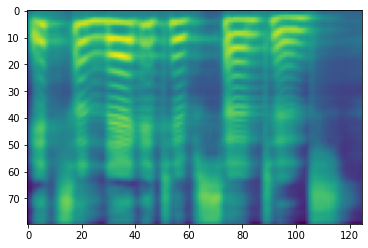

In [61]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = response

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, _, _ = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

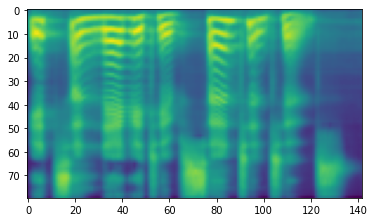

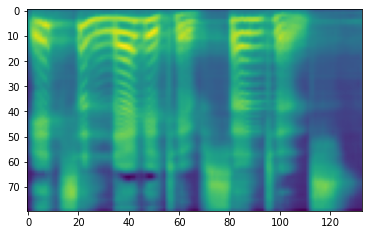

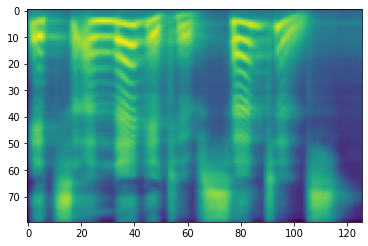

In [62]:
for _ in range(3):
  with torch.inference_mode():
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  plt.imshow(spec[0].cpu().detach())
  plt.show()

In [63]:
# %%timeit
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = response

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


In [64]:
# # %%timeit
# bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

# processor = bundle.get_text_processor()
# tacotron2 = bundle.get_tacotron2().to(device)
# vocoder = bundle.get_vocoder().to(device)

# with torch.inference_mode():
#   processed, lengths = processor(text)
#   processed = processed.to(device)
#   lengths = lengths.to(device)
#   spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
# waveforms, lengths = vocoder(spec, spec_lengths)

# torchaudio.save("output_griffinlim.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
# IPython.display.display(IPython.display.Audio("output_griffinlim.wav"))

In [ ]:
# %%timeit
# bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH

# processor = bundle.get_text_processor()
# tacotron2 = bundle.get_tacotron2().to(device)
# vocoder = bundle.get_vocoder().to(device)

# with torch.inference_mode():
#   processed, lengths = processor(text)
#   processed = processed.to(device)
#   lengths = lengths.to(device)
#   spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
# waveforms, lengths = vocoder(spec, spec_lengths)

# torchaudio.save("output_griffinlimchar.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
# IPython.display.display(IPython.display.Audio("output_griffinlimchar.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_characters_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_characters_1500_epochs_ljspeech.pth


In [ ]:
# %%timeit
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = response

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_wavernnchar.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernnchar.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_characters_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_characters_1500_epochs_wavernn_ljspeech.pth


In [69]:
def run():

  print(ourdataset)
  results1 = ourdataset.map(map_to_result)
  print(results1["sampling_rate"])
  show_random_elements(results1.remove_columns(["speech", "sampling_rate"]))

  res = results1[0]["pred_str"]
  print(res)

  response = ""

  if(res == "what's the sentiment of i hate mondays"):
    text = res
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)

    print(labels[ranking[2]])
    response = labels[ranking[2]]
  else:
    response = "Please try again"

  bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

  processor = bundle.get_text_processor()
  tacotron2 = bundle.get_tacotron2().to(device)
  vocoder = bundle.get_vocoder().to(device)

  text = response

  with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

  torchaudio.save("output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
  IPython.display.display(IPython.display.Audio("output_wavernn.wav"))
    

  return 0

In [70]:
run()

Dataset({
    features: ['file', 'sampling_rate', 'speech', 'target_text', 'text'],
    num_rows: 6
})


TypeError: ignored